In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
%matplotlib inline
# %matplotlib notebook
# from Ipython import display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from sklearn import tree
import csv
from sklearn.neighbors import KNeighborsClassifier
from heapq import heappush, heappop
import math

### General Helper Functions

In [2]:
def split_test_train(X, y, percent=0.8):
    mask = np.random.rand(len(X)) < percent
    X_train = X[mask].dropna()
    X_test = X[~mask].dropna()
    y_train = y[mask].dropna()
    y_test = y[~mask].dropna()
    print(X_train.shape, X_test.shape)
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    return X_train, X_test, y_train, y_test

In [3]:
def evaluate_result(y_test, y_pred):
    pprint(confusion_matrix(y_test, y_pred))
    #     tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    #     print("tn = {0}, fp = {1}, fn = {2}, tp = {3}".format(tn, fp, fn, tp))
    f1 = f1_score(y_test, y_pred, average="macro")
    print("f1_score\t : ", f1)
    ps = precision_score(y_test, y_pred, average="macro")
    print("precision_score\t : ", ps)
    rs = recall_score(y_test, y_pred, average="macro")
    print("recall_score\t : ", rs)
    acs = accuracy_score(y_test, y_pred)
    print("accuracy_score\t : ", acs)
    return np.array([f1, ps, rs, acs])

### Distance Functions
- euclid \begin{equation*}
x=\sqrt{ \sum_{i=0}^n x_{i} - y_{i}}
\end{equation*}


In [4]:
def euclid(test_row, train_row):
    dis = np.sqrt(np.sum([(x - y)**2 for x, y in zip(test_row, train_row)]))
    return dis


def manhattan(test_row, train_row):
    dis = np.sum([abs(x - y) for x, y in zip(train_row, test_row)])
    return dis


def chebyshew(test_row, train_row):
    dis = np.max([abs(x - y) for x, y in zip(train_row, test_row)])
    return dis

# Part 1: KNN Classifier
KNN class

In [5]:
class KNN:
    def fit(self, train_X, train_y, k=3, distance_function=euclid):
        self.train_X = train_X
        self.train_y = train_y
        self.k = k
        self.distance_function = distance_function

    def predict_row(self, test_row):
        heap = []
        for (index, train_row) in self.train_X.iterrows():
            dis = -self.distance_function(train_row, test_row)
            x = (dis, self.train_y.iloc[index, 0])
            heappush(heap, x)
            if len(heap) > self.k:
                heappop(heap)
        elem, count = np.unique([i for j, i in heap], return_counts=True)
        return elem[np.argmax(count)]

    def predict(self, test_X):
        test_y = pd.DataFrame()
        test_y['predicted'] = [
            self.predict_row(row) for i, row in test_X.iterrows()
        ]
        return test_y

    def evaluate_result(self, y_test, y_pred):
        pprint(confusion_matrix(y_test, y_pred))
        #         tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        #         print("tn = {0}, fp = {1}, fn = {2}, tp = {3}".format(tn, fp, fn, tp))
        f1 = f1_score(y_test, y_pred, average="macro")
        print("f1_score\t : ", f1)
        ps = precision_score(y_test, y_pred, average="macro")
        print("precision_score\t : ", ps)
        rs = recall_score(y_test, y_pred, average="macro")
        print("recall_score\t : ", rs)
        acs = accuracy_score(y_test, y_pred)
        print("accuracy_score\t : ", acs)
        return np.array([f1, ps, rs, acs])

    def set_k(self, k):
        self.k = k

### Wrapper function that will split data and return accuracy, f1 score, precision, recall 

In [6]:
def run_KNN(data, label, k=3, distance_function=euclid):
    y = data[[label]]
    X = data.drop(label, 1)
    print(X.shape, y.shape, data.shape)
    train_X, test_X, train_y, test_y = split_test_train(X, y, 0.8)
    print(len(train_X), train_X.tail())
    classifier = KNN()
    classifier.fit(train_X, train_y, k, distance_function)
    y_predict = classifier.predict(test_X)
    result1 = classifier.evaluate_result(test_y, y_predict)
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(train_X, train_y.values.ravel())
    predicted = model.predict(test_X)
    result2 = evaluate_result(test_y, predicted)
    return result1, result2

### Wrapper Function for scikit learn KNN

In [7]:
def run_scikit_KNN(data, label, k=3):
    y = data[[label]]
    X = data.drop(label, 1)
    print(X.shape, y.shape, data.shape)
    train_X, test_X, train_y, test_y = split_test_train(X, y, 0.8)
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(train_X, train_y)
    predicted = model.predict(test_X)
    evaluate_result(test_y, predicted)

### PART 1.A : Function for comparing result with scikit learn for various k 

In [8]:
def compare_res(data, label, distance_function=euclid):
    KNN_res = np.zeros(shape=(11, 4))
    KNN_scikit_res = np.zeros(shape=(11, 4))
    for i in range(1, 12):
        r1, r2 = run_KNN(data, label, i)
        KNN_res[i - 1] = r1
        KNN_scikit_res[i - 1] = r2
    KNN_res = KNN_res.T
    KNN_scikit_res = KNN_scikit_res.T
    n_neighbour = [i for i in range(1, 12)]
    plt.figure(1)
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.legend(line1)
        plt.plot(n_neighbour, KNN_res[i], label="my_KNN")
        plt.plot(n_neighbour, KNN_scikit_res[i], label = "scikit_KNN")

### PART 1.B : Function for comparing result with scikit learn for various distance fucntions

In [9]:
def compare_distance_function(data, label):
    distance_functions = [euclid, manhattan, chebyshew]
    plt.figure(1)
    for distance in distance_functions:
        KNN_res = np.zeros(shape=(11, 4))
        for i in range(1, 12):
            r1, r2 = run_KNN(data, label, i, distance)
            KNN_res[i - 1] = r1
        KNN_res = KNN_res.T
        n_neighbour = [i for i in range(1, 12)]
        for i in range(4):
            plt.subplot(2, 2, i + 1)
            plt.legend(loc='best')
            plt.plot(n_neighbour, KNN_res[i], label=distance.__name__)

### Robot data1

In [10]:
robot1 = pd.read_csv('RobotDataset/Robot1')
robot2 = pd.read_csv('RobotDataset/Robot2')
list(robot1.columns.values)
robot1 = robot1.drop('Unnamed: 0', 1)
robot2 = robot2.drop('Unnamed: 0', 1)
robot1 = robot1.drop('id', 1)
robot2 = robot2.drop('id', 1)

In [11]:
display(robot1.head())
display(robot2.head())
display(robot1.describe())
display(robot2.describe())

,class,A1,A2,A3,A4,A5,A6
0,1,1,1,1,1,3,1
1,1,1,1,1,1,3,2
2,1,1,1,1,3,2,1
3,1,1,1,1,3,3,2
4,1,1,1,2,1,2,1


,class,A1,A2,A3,A4,A5,A6
0,1,1,1,1,1,1,2
1,1,1,1,1,1,2,1
2,1,1,1,1,1,2,2
3,0,1,1,1,1,3,1
4,0,1,1,1,1,4,1


,class,A1,A2,A3,A4,A5,A6
count,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000
mean,0.500000,1.935484,2.096774,1.475806,2.008065,2.556452,1.548387
std,0.502028,0.813923,0.810694,0.501440,0.831259,1.128366,0.499672
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000
50%,0.500000,2.000000,2.000000,1.000000,2.000000,3.000000,2.000000
75%,1.000000,3.000000,3.000000,2.000000,3.000000,4.000000,2.000000
max,1.000000,3.000000,3.000000,2.000000,3.000000,4.000000,2.000000


,class,A1,A2,A3,A4,A5,A6
count,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000
mean,0.491803,1.885246,2.016393,1.467213,2.032787,2.475410,1.516393
std,0.501994,0.815113,0.812949,0.500981,0.832545,1.137004,0.501792
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,0.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000
75%,1.000000,3.000000,3.000000,2.000000,3.000000,3.750000,2.000000
max,1.000000,3.000000,3.000000,2.000000,3.000000,4.000000,2.000000


In [12]:
robot1.isnull().values.any()
robot2.isnull().values.any()

False

In [13]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

In [14]:
run_KNN(robot1, 'class', k=5)

(124, 6) (124, 1) (124, 7)
(94, 6) (30, 6)
94     A1  A2  A3  A4  A5  A6
89   3   3   2   1   3   2
90   3   3   2   1   4   2
91   3   3   2   3   2   2
92   3   3   2   3   3   2
93   3   3   2   3   4   2
array([[ 7,  7],
       [ 2, 14]])
f1_score	 :  0.6827262044653348
precision_score	 :  0.7222222222222222
recall_score	 :  0.6875
accuracy_score	 :  0.7
array([[10,  4],
       [ 3, 13]])
f1_score	 :  0.7643097643097644
precision_score	 :  0.7669683257918551
recall_score	 :  0.7633928571428572
accuracy_score	 :  0.7666666666666667


(array([0.6827262 , 0.72222222, 0.6875    , 0.7       ]),
 array([0.76430976, 0.76696833, 0.76339286, 0.76666667]))

(122, 6) (122, 1) (122, 7)
(101, 6) (21, 6)
101      A1  A2  A3  A4  A5  A6
96    3   3   1   3   4   1
97    3   3   2   1   1   1
98    3   3   2   1   1   2
99    3   3   2   3   3   2
100   3   3   2   3   4   2
array([[10,  4],
       [ 0,  7]])
f1_score	 :  0.8055555555555556
precision_score	 :  0.8181818181818181
recall_score	 :  0.8571428571428572
accuracy_score	 :  0.8095238095238095
array([[13,  1],
       [ 0,  7]])
f1_score	 :  0.9481481481481482
precision_score	 :  0.9375
recall_score	 :  0.9642857142857143
accuracy_score	 :  0.9523809523809523
(122, 6) (122, 1) (122, 7)
(106, 6) (16, 6)
106      A1  A2  A3  A4  A5  A6
101   3   3   2   2   2   2
102   3   3   2   2   3   2
103   3   3   2   3   1   1
104   3   3   2   3   3   2
105   3   3   2   3   4   2
array([[9, 3],
       [1, 3]])
f1_score	 :  0.7090909090909091
precision_score	 :  0.7
recall_score	 :  0.75
accuracy_score	 :  0.75
array([[12,  0],
       [ 1,  3]])
f1_score	 :  0.9085714285714286
precision_score	 :  

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


array([[ 4,  2],
       [ 2, 13]])
f1_score	 :  0.7666666666666666
precision_score	 :  0.7666666666666666
recall_score	 :  0.7666666666666666
accuracy_score	 :  0.8095238095238095
array([[ 5,  1],
       [ 3, 12]])
f1_score	 :  0.7857142857142857
precision_score	 :  0.7740384615384616
recall_score	 :  0.8166666666666667
accuracy_score	 :  0.8095238095238095


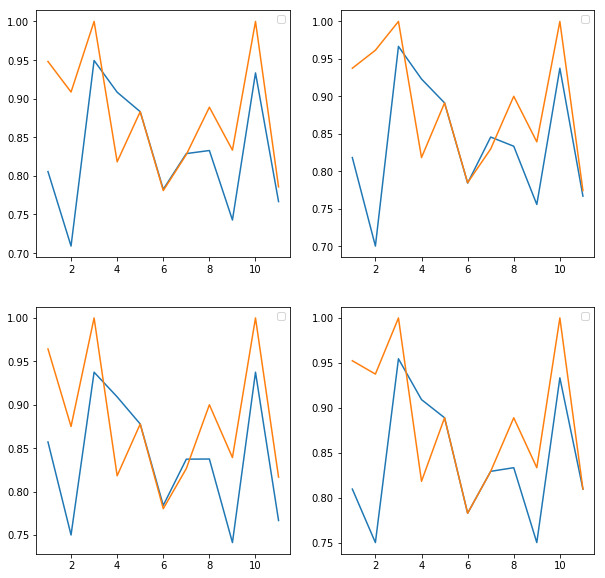

In [15]:
# compare_res(robot1, 'class')
compare_res(robot2, 'class')

In [16]:
def convert_categorical_to_numerical(data):
    res = pd.factorize(data)
    x, y = res
    return x, y

In [17]:
iris_data = pd.read_csv("Iris/Iris.csv")
print(iris_data.head())

   sepal_length  sepal_width  petal_length  petal_width           class
0           5.1          3.5           1.4          0.2     Iris-setosa
1           6.3          3.3           6.0          2.5  Iris-virginica
2           5.0          3.0           1.6          0.2     Iris-setosa
3           6.2          2.8           4.8          1.8  Iris-virginica
4           6.4          3.1           5.5          1.8  Iris-virginica


In [18]:
columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
for column in columns:
    iris_data[column] = (iris_data[column] - iris_data[column].min()) / (
        iris_data[column].max() - iris_data[column].min())

In [19]:
display(iris_data.head())

,sepal_length,sepal_width,petal_length,petal_width,class
0,0.222222,0.625000,0.067797,0.041667,Iris-setosa
1,0.555556,0.541667,0.847458,1.000000,Iris-virginica
2,0.194444,0.416667,0.101695,0.041667,Iris-setosa
3,0.527778,0.333333,0.644068,0.708333,Iris-virginica
4,0.583333,0.458333,0.762712,0.708333,Iris-virginica


In [20]:
array, convert_back_Iris_to_categorical = convert_categorical_to_numerical(
    iris_data['class'])
iris_data['class'] = array

In [21]:
Iris_X = iris_data.drop('class', 1)
Iris_y = iris_data[['class']]
Iris_train_X, Iris_test_X, Iris_train_y, Iris_test_y = split_test_train(
    Iris_X, Iris_y)

(103, 4) (32, 4)


In [22]:
classifier_iris = KNN()
classifier_iris.fit(Iris_train_X, Iris_train_y, 2)
y_predict_iris = classifier_iris.predict(Iris_test_X)
print(Iris_test_y.shape, y_predict_iris.shape)
classifier_iris.evaluate_result(Iris_test_y, y_predict_iris)

(32, 1) (32, 1)
array([[10,  0,  0],
       [ 0, 11,  0],
       [ 0,  0, 11]])
f1_score	 :  1.0
precision_score	 :  1.0
recall_score	 :  1.0
accuracy_score	 :  1.0


array([1., 1., 1., 1.])

(135, 4) (135, 1) (135, 5)
(110, 4) (25, 4)
110      sepal_length  sepal_width  petal_length  petal_width
105      0.694444     0.500000      0.830508     0.916667
106      0.444444     0.500000      0.644068     0.708333
107      0.805556     0.666667      0.864407     1.000000
108      0.333333     0.166667      0.474576     0.416667
109      0.388889     0.416667      0.542373     0.458333
array([[7, 0, 0],
       [0, 9, 1],
       [0, 0, 8]])
f1_score	 :  0.9628482972136223
precision_score	 :  0.9629629629629629
recall_score	 :  0.9666666666666667
accuracy_score	 :  0.96
array([[7, 0, 0],
       [0, 9, 1],
       [0, 0, 8]])
f1_score	 :  0.9628482972136223
precision_score	 :  0.9629629629629629
recall_score	 :  0.9666666666666667
accuracy_score	 :  0.96
(135, 4) (135, 1) (135, 5)
(105, 4) (30, 4)
105      sepal_length  sepal_width  petal_length  petal_width
100      0.694444     0.500000      0.830508     0.916667
101      0.444444     0.500000      0.644068     0.708333
102      0

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


array([[7, 0, 0],
       [0, 8, 0],
       [0, 0, 7]])
f1_score	 :  1.0
precision_score	 :  1.0
recall_score	 :  1.0
accuracy_score	 :  1.0
array([[7, 0, 0],
       [0, 8, 0],
       [0, 0, 7]])
f1_score	 :  1.0
precision_score	 :  1.0
recall_score	 :  1.0
accuracy_score	 :  1.0


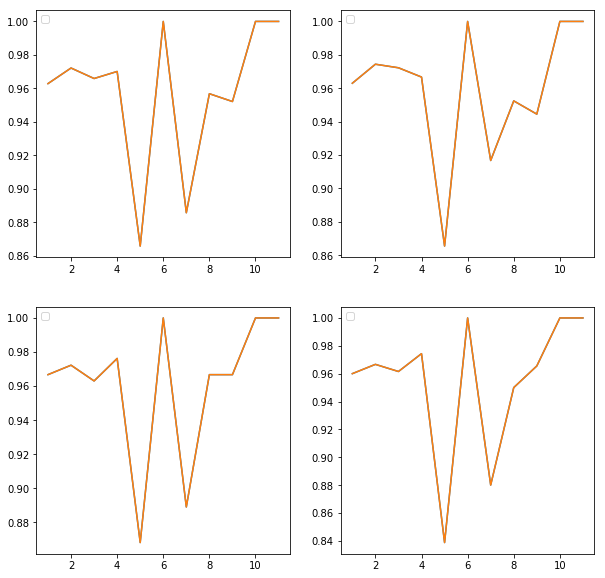

In [23]:
compare_res(iris_data, 'class')

(135, 4) (135, 1) (135, 5)
(109, 4) (26, 4)
109      sepal_length  sepal_width  petal_length  petal_width
104      0.444444     0.500000      0.644068     0.708333
105      0.166667     0.458333      0.084746     0.000000
106      0.805556     0.666667      0.864407     1.000000
107      0.333333     0.166667      0.474576     0.416667
108      0.388889     0.416667      0.542373     0.458333
array([[9, 0, 0],
       [0, 9, 1],
       [0, 0, 7]])
f1_score	 :  0.960233918128655
precision_score	 :  0.9583333333333334
recall_score	 :  0.9666666666666667
accuracy_score	 :  0.9615384615384616
array([[9, 0, 0],
       [0, 9, 1],
       [0, 0, 7]])
f1_score	 :  0.960233918128655
precision_score	 :  0.9583333333333334
recall_score	 :  0.9666666666666667
accuracy_score	 :  0.9615384615384616
(135, 4) (135, 1) (135, 5)
(111, 4) (24, 4)
111      sepal_length  sepal_width  petal_length  petal_width
106      0.138889     0.583333      0.101695     0.041667
107      0.555556     0.125000      0.5762

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


array([[11,  0,  0],
       [ 0,  8,  0],
       [ 0,  0,  5]])
f1_score	 :  1.0
precision_score	 :  1.0
recall_score	 :  1.0
accuracy_score	 :  1.0
array([[11,  0,  0],
       [ 0,  8,  0],
       [ 0,  0,  5]])
f1_score	 :  1.0
precision_score	 :  1.0
recall_score	 :  1.0
accuracy_score	 :  1.0
(135, 4) (135, 1) (135, 5)
(107, 4) (28, 4)
107      sepal_length  sepal_width  petal_length  petal_width
102      0.444444     0.500000      0.644068     0.708333
103      0.722222     0.458333      0.745763     0.833333
104      0.166667     0.458333      0.084746     0.000000
105      0.333333     0.166667      0.474576     0.416667
106      0.388889     0.416667      0.542373     0.458333
array([[ 6,  0,  0],
       [ 0, 12,  1],
       [ 0,  0,  9]])
f1_score	 :  0.9691228070175439
precision_score	 :  0.9666666666666667
recall_score	 :  0.9743589743589745
accuracy_score	 :  0.9642857142857143
array([[ 6,  0,  0],
       [ 0, 12,  1],
       [ 0,  0,  9]])
f1_score	 :  0.9691228070175439
p

array([[ 5,  0,  0],
       [ 0, 10,  1],
       [ 0,  1, 10]])
f1_score	 :  0.9393939393939394
precision_score	 :  0.9393939393939394
recall_score	 :  0.9393939393939394
accuracy_score	 :  0.9259259259259259
array([[ 5,  0,  0],
       [ 0, 10,  1],
       [ 0,  1, 10]])
f1_score	 :  0.9393939393939394
precision_score	 :  0.9393939393939394
recall_score	 :  0.9393939393939394
accuracy_score	 :  0.9259259259259259
(135, 4) (135, 1) (135, 5)
(107, 4) (28, 4)
107      sepal_length  sepal_width  petal_length  petal_width
102      0.555556     0.125000      0.576271     0.500000
103      0.694444     0.500000      0.830508     0.916667
104      0.722222     0.458333      0.745763     0.833333
105      0.166667     0.458333      0.084746     0.000000
106      0.388889     0.416667      0.542373     0.458333
array([[11,  0,  0],
       [ 0,  8,  0],
       [ 0,  0,  9]])


/home/aman/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/aman/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/aman/anaconda3/lib/python3.6/site-packages/matplotlib/cb

f1_score	 :  1.0
precision_score	 :  1.0
recall_score	 :  1.0
accuracy_score	 :  1.0
array([[11,  0,  0],
       [ 0,  8,  0],
       [ 0,  2,  7]])
f1_score	 :  0.9212962962962963
precision_score	 :  0.9333333333333332
recall_score	 :  0.9259259259259259
accuracy_score	 :  0.9285714285714286
(135, 4) (135, 1) (135, 5)
(111, 4) (24, 4)
111      sepal_length  sepal_width  petal_length  petal_width
106      0.444444     0.500000      0.644068     0.708333
107      0.722222     0.458333      0.745763     0.833333
108      0.166667     0.458333      0.084746     0.000000
109      0.333333     0.166667      0.474576     0.416667
110      0.388889     0.416667      0.542373     0.458333
array([[9, 0, 0],
       [0, 8, 0],
       [0, 0, 7]])
f1_score	 :  1.0
precision_score	 :  1.0
recall_score	 :  1.0
accuracy_score	 :  1.0
array([[9, 0, 0],
       [0, 8, 0],
       [0, 0, 7]])
f1_score	 :  1.0
precision_score	 :  1.0
recall_score	 :  1.0
accuracy_score	 :  1.0
(135, 4) (135, 1) (135, 5)
(10

/home/aman/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/aman/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/aman/anaconda3/lib/python3.6/site-packages/matplotlib/cb

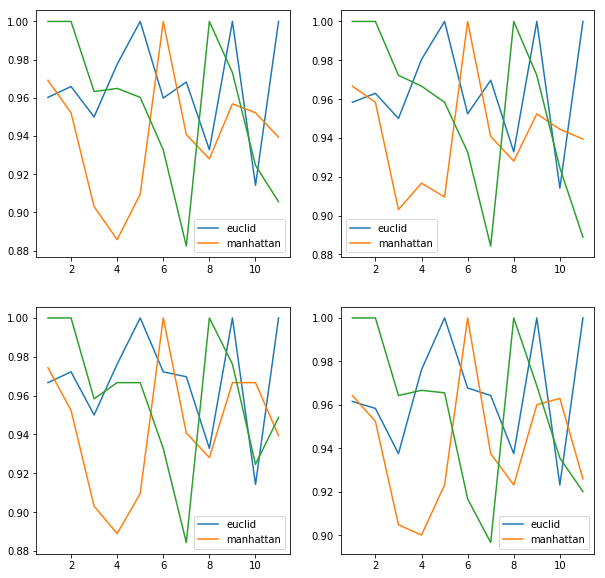

In [24]:
compare_distance_function(iris_data, 'class')

## Part 2

In [36]:
class NaiveBayes():
    def calculate_count(self, df):
        labels, counts = np.unique(df, return_counts=True)
        return zip(labels, counts)

    def seperate_by_class(self):
        self.continuous_summary = pd.DataFrame(
            columns=self.continuous_features)
        self.categorical_summary = pd.DataFrame(
            columns=self.categorical_features)
        distinct_classes = np.unique(self.train_y)
        self.train_X['class'] = self.train_y
        self.class_frequency = {}
        for label in distinct_classes:
            class_data = self.train_X.where(
                self.train_X['class'] == label).dropna()
            self.continuous_summary.loc[label] = [{
                'mean':
                class_data[column].mean(),
                'std_dev':
                class_data[column].std()
            } for column in self.continuous_features]
            self.class_frequency[label] = len(class_data) / len(self.train_X)
            #             print(np.unique(class_data['credit_card'], return_counts=True))
            self.categorical_summary.loc[label] = [{
                value: count / len(class_data)
                for (value, count) in self.calculate_count(class_data[column])
            } for column in categorical_features]
        self.train_X = self.train_X.drop('class', 1)
        display(self.continuous_summary)
        display(self.categorical_summary)

    def calculate_probability(self, x, mean, std_dev):
        exponent = math.exp((-(x - mean)**2) / (2 * (std_dev**2)))
        return (1 / (math.sqrt(2 * math.pi) * std_dev)) * exponent

    def train(self, train_X, train_y, categorical_features,
              continuous_features):
        self.train_X = train_X
        self.train_y = train_y
        self.categorical_features = categorical_features
        self.continuous_features = continuous_features
        self.seperate_by_class()

    def predict_row(self, query):
        continuous_probability = []
        for index, row in self.continuous_summary.iterrows():
            continuous_probability.append(
                np.prod([
                    self.calculate_probability(query[key], row[key]['mean'],
                                               row[key]['std_dev'])
                    for key in self.continuous_features
                ])* self.class_frequency[index])
        categorical_probability = []
        for index, row in self.categorical_summary.iterrows():
            categorical_probability.append(
                np.prod([
                    row[key][query[key]] for key in self.categorical_features
                ]) * self.class_frequency[index])
        probability = [
            i * j
            for i, j in zip(continuous_probability, categorical_probability)
        ]
        return list(
            self.categorical_summary.index.values)[np.argmax(probability)]

    def predict(self, test_X):
        test_y = pd.DataFrame()
        queries = test_X.to_dict(orient="records")
        test_y['predicted'] = [self.predict_row(row) for row in queries]
        return test_y

In [37]:
Bank_data = pd.read_csv('LoanDataset/data.csv')
categorical_features = [
    'education_level',
    'certificate_of_deposit',
    'internet_banking',
    'credit_card'  #,'zip'
]
label = 'class'
continuous_features = [
    'age', 'no_of_year_of_exp', 'annual_income', 'family_size',
    'average_spending', 'motgage_value', 'security_account'
]
Bank_y = Bank_data[[label]]
Bank_X = Bank_data.drop(label, 1)
# print(X.shape, y.shape, data.shape)
Bank_train_X, Bank_test_X, Bank_train_y, Bank_test_y = split_test_train(
    Bank_X, Bank_y, 0.8)

(3621, 13) (878, 13)


In [38]:
Bank_data.head()

,ID,age,no_of_year_of_exp,annual_income,zip,family_size,average_spending,education_level,motgage_value,class,security_account,certificate_of_deposit,internet_banking,credit_card
0,2701,31,5,39,94590,4,2.2,2,0,0,0,0,1,1
1,2716,42,18,54,90089,1,1.8,1,0,0,0,0,1,0
2,3359,59,35,40,94536,4,0.4,1,0,0,0,0,0,0
3,2492,38,14,80,92868,2,2.7,1,0,0,0,0,1,0
4,937,62,32,19,92109,1,1.5,3,0,0,1,0,0,0


In [39]:
Bank_data.describe()

,ID,age,no_of_year_of_exp,annual_income,zip,family_size,average_spending,education_level,motgage_value,class,security_account,certificate_of_deposit,internet_banking,credit_card
count,4499.000000,4499.000000,4499.000000,4499.000000,4499.000000,4499.000000,4499.000000,4499.000000,4499.000000,4499.000000,4499.000000,4499.000000,4499.000000,4499.000000
mean,2496.199378,45.373861,20.138253,73.998666,93136.864859,2.396977,1.938713,1.882863,56.460102,0.096466,0.106246,0.060680,0.601912,0.292509
std,1441.839845,11.458949,11.460509,45.961247,2159.488849,1.145195,1.745968,0.840196,101.781134,0.295262,0.308186,0.238769,0.489558,0.454966
min,2.000000,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1250.500000,35.000000,10.000000,39.000000,91902.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2495.000000,45.000000,20.000000,64.000000,93407.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,3748.500000,55.000000,30.000000,98.000000,94608.000000,3.000000,2.600000,3.000000,101.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [40]:
print(np.unique(Bank_data['class'], return_counts=True))

(array([0, 1]), array([4065,  434]))


In [41]:
NB = NaiveBayes()
NB.train(Bank_train_X, Bank_train_y, categorical_features, continuous_features)

,age,no_of_year_of_exp,annual_income,family_size,average_spending,motgage_value,security_account
0,"{'mean': 45.413096695226436, 'std_dev': 11.370...","{'mean': 20.16768665850673, 'std_dev': 11.3729...","{'mean': 66.40575275397796, 'std_dev': 40.3942...","{'mean': 2.3812729498164016, 'std_dev': 1.1521...","{'mean': 1.7278518971848227, 'std_dev': 1.5694...","{'mean': 51.96083231334149, 'std_dev': 92.3297...","{'mean': 0.10373317013463892, 'std_dev': 0.304..."
1,"{'mean': 45.09065155807365, 'std_dev': 11.5889...","{'mean': 19.875354107648725, 'std_dev': 11.536...","{'mean': 144.80736543909347, 'std_dev': 31.717...","{'mean': 2.5892351274787537, 'std_dev': 1.1374...","{'mean': 3.945892351274789, 'std_dev': 2.07350...","{'mean': 98.79320113314448, 'std_dev': 157.921...","{'mean': 0.13031161473087818, 'std_dev': 0.337..."


,education_level,certificate_of_deposit,internet_banking,credit_card
0,"{1.0: 0.44339045287637696, 2.0: 0.264687882496...","{0.0: 0.9660342717258262, 1.0: 0.0339657282741...","{0.0: 0.40269277845777235, 1.0: 0.597307221542...","{0.0: 0.7117503059975521, 1.0: 0.288249694002448}"
1,"{1.0: 0.18980169971671387, 2.0: 0.365439093484...","{0.0: 0.6968838526912181, 1.0: 0.3031161473087...","{0.0: 0.3937677053824363, 1.0: 0.6062322946175...","{0.0: 0.7082152974504249, 1.0: 0.2917847025495..."


In [42]:
predicted_bank = NB.predict(Bank_test_X)
evaluate_result(Bank_test_y, predicted_bank)

array([[767,  30],
       [ 54,  27]])
f1_score	 :  0.6696942011071102
precision_score	 :  0.7039553817552407
recall_score	 :  0.6478460895023003
accuracy_score	 :  0.9043280182232346


array([0.6696942 , 0.70395538, 0.64784609, 0.90432802])

In [35]:
print(Bank_data.columns.values)

['ID' 'age' 'no_of_year_of_exp' 'annual_income' 'zip' 'family_size'
 'average_spending' 'education_level' 'motgage_value' 'class'
 'security_account' 'certificate_of_deposit' 'internet_banking'
 'credit_card']
